In [34]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 

In [35]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [36]:
df = pd.read_csv("C:\\Users\\karti\\Desktop\\CCFD_files\\creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split data by 50-50

In [37]:
TEST_RATIO = 0.5
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

## Pre-processing - z scores

In [38]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## import RBM

In [39]:
def sample_prob(probs, rand):
    """ Takes a tensor of probabilities (as from a sigmoidal activation)
    and samples from all the distributions
    :param probs: tensor of probabilities
    :param rand: tensor (of the same shape as probs) of random values
    :return : binary sample of probabilities
    """
    return tf.nn.relu(tf.sign(probs - rand))

def gen_batches(data, batch_size):
    """ Divide input data into batches.
    :param data: input data
    :param batch_size: size of each batch
    :return: data divided into batches
    """
    data = np.array(data)

    for i in range(0, data.shape[0], batch_size):
        yield data[i:i+batch_size]

def gen_image(img, width, height, outfile, img_type='grey'):
    assert len(img) == width * height or len(img) == width * height * 3

    if img_type == 'grey':
        misc.imsave(outfile, img.reshape(width, height))

    elif img_type == 'color':
        misc.imsave(outfile, img.reshape(3, width, height))


class RBM(object):

    """ Restricted Boltzmann Machine implementation using TensorFlow.
    The interface of the class is sklearn-like.
    """

    def __init__(self, num_visible, num_hidden, visible_unit_type='bin', main_dir="C:\\Users\\karti\\Desktop\\CCFD_files\\Model", model_name='rbm_model',
                 gibbs_sampling_steps=1, learning_rate=0.01, momentum = 0.9, l2 = 0.001, batch_size=10, num_epochs=50, stddev=0.1, verbose=0, plot_training_loss=True):

        """
        :param num_visible: number of visible units
        :param num_hidden: number of hidden units
        :param visible_unit_type: type of the visible units (binary or gaussian)
        :param main_dir: main directory to put the models, data and summary directories
        :param model_name: name of the model, used to save data
        :param gibbs_sampling_steps: optional, default 1
        :param learning_rate: optional, default 0.01
        :param momentum: momentum for gradient descent, default 0.9
        :param l2: l2 weight decay, default 0.001
        :param batch_size: optional, default 10
        :param num_epochs: optional, default 10
        :param stddev: optional, default 0.1. Ignored if visible_unit_type is not 'gauss'
        :param verbose: level of verbosity. optional, default 0
        :param plot_training_loss: whether or not to plot training loss, default True
        """

        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.visible_unit_type = visible_unit_type
        self.main_dir = main_dir
        self.model_name = model_name
        self.gibbs_sampling_steps = gibbs_sampling_steps
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.l2 = l2
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.stddev = stddev
        self.verbose = verbose

        self._create_model_directory()
        self.model_path = os.path.join(self.main_dir, self.model_name)
        self.plot_training_loss = plot_training_loss

        self.W = None
        self.bh_ = None
        self.bv_ = None
        self.dw = None
        self.dbh_ = None 
        self.dbv_ = None

        self.w_upd8 = None
        self.bh_upd8 = None
        self.bv_upd8 = None

        self.encode = None
        self.recontruct = None

        self.loss_function = None
        self.batch_cost = None
        self.batch_free_energy = None

        self.training_losses = []

        self.input_data = None
        self.hrand = None
        self.validation_size = None

        self.tf_session = None
        self.tf_saver = None

    def fit(self, train_set, validation_set=None, restore_previous_model=False):

        """ Fit the model to the training data.
        :param train_set: training set
        :param validation_set: validation set. optional, default None
        :param restore_previous_model:
                    if true, a previous trained model
                    with the same name of this model is restored from disk to continue training.
        :return: self
        """

        if validation_set is not None:
            self.validation_size = validation_set.shape[0]

        tf.reset_default_graph()

        self._build_model()

        with tf.Session() as self.tf_session:

            self._initialize_tf_utilities_and_ops(restore_previous_model)
            self._train_model(train_set, validation_set)
            self.tf_saver.save(self.tf_session, self.model_path)

            if self.plot_training_loss:
                plt.plot(self.training_losses)
                plt.title("Training batch losses v.s. iteractions")
                plt.xlabel("Num of training iteractions")
                plt.ylabel("Reconstruction error")
                plt.show()

    def _initialize_tf_utilities_and_ops(self, restore_previous_model):

        """ Initialize TensorFlow operations: summaries, init operations, saver, summary_writer.
        Restore a previously trained model if the flag restore_previous_model is true.
        """

        init_op = tf.global_variables_initializer()
        self.tf_saver = tf.train.Saver()

        self.tf_session.run(init_op)

        if restore_previous_model:
            self.tf_saver.restore(self.tf_session, self.model_path)

    def _train_model(self, train_set, validation_set):

        """ Train the model.
        :param train_set: training set
        :param validation_set: validation set. optional, default None
        :return: self
        """

        for i in range(self.num_epochs):
            self._run_train_step(train_set)

            if validation_set is not None:
                self._run_validation_error(i, validation_set)

    def _run_train_step(self, train_set):

        """ Run a training step. A training step is made by randomly shuffling the training set,
        divide into batches and run the variable update nodes for each batch. If self.plot_training_loss 
        is true, will record training loss after each batch. 
        :param train_set: training set
        :return: self
        """

        np.random.shuffle(train_set)

        batches = [_ for _ in gen_batches(train_set, self.batch_size)]
        updates = [self.w_upd8, self.bh_upd8, self.bv_upd8]


        for batch in batches:
            if self.plot_training_loss:
                _, loss = self.tf_session.run([updates, self.loss_function], feed_dict=self._create_feed_dict(batch))
                self.training_losses.append(loss)
            else:
                self.tf_session.run(updates, feed_dict=self._create_feed_dict(batch))

    def _run_validation_error(self, epoch, validation_set):

        """ Run the error computation on the validation set and print it out for each epoch. 
        :param epoch: current epoch
        :param validation_set: validation data
        :return: self
        """

        loss = self.tf_session.run(self.loss_function,
                                   feed_dict=self._create_feed_dict(validation_set))

        if self.verbose == 1:
            print("Validation cost at step %s: %s" % (epoch, loss))

    def _create_feed_dict(self, data):

        """ Create the dictionary of data to feed to TensorFlow's session during training.
        :param data: training/validation set batch
        :return: dictionary(self.input_data: data, self.hrand: random_uniform)
        """

        return {
            self.input_data: data,
            self.hrand: np.random.rand(data.shape[0], self.num_hidden),
        }

    def _build_model(self):

        """ Build the Restricted Boltzmann Machine model in TensorFlow.
        :return: self
        """

        self.input_data, self.hrand = self._create_placeholders()
        self.W, self.bh_, self.bv_, self.dw, self.dbh_, self.dbv_ = self._create_variables()

        hprobs0, hstates0, vprobs, hprobs1, hstates1 = self.gibbs_sampling_step(self.input_data)
        positive = self.compute_positive_association(self.input_data, hprobs0, hstates0)

        nn_input = vprobs

        for step in range(self.gibbs_sampling_steps - 1):
            hprobs, hstates, vprobs, hprobs1, hstates1 = self.gibbs_sampling_step(nn_input)
            nn_input = vprobs

        self.recontruct = vprobs

        negative = tf.matmul(tf.transpose(vprobs), hprobs1)

        self.encode = hprobs1  # encoded data, used by the transform method

        dw = positive - negative
        self.dw = self.momentum*self.dw + (1-self.momentum)*dw
        self.w_upd8 = self.W.assign_add(self.learning_rate*self.dw - self.learning_rate*self.l2*self.W)

        dbh_ = tf.reduce_mean(hprobs0 - hprobs1, 0)
        self.dbh_ = self.momentum*self.dbh_ + self.learning_rate*dbh_
        self.bh_upd8 = self.bh_.assign_add(self.dbh_)

        dbv_ = tf.reduce_mean(self.input_data - vprobs, 0)
        self.dbv_ = self.momentum*self.dbv_ + self.learning_rate*dbv_
        self.bv_upd8 = self.bv_.assign_add(self.dbv_)

        """ method 2 for updating with momentum
        def _update_with_momentum(x_old, x_new):
            return self.momentum * x_old +\
                   self.learning_rate * x_new * (1 - self.momentum) 

        dw = positive - negative
        self.dw = _update_with_momentum(self.dw, dw)
        self.w_upd8 = self.W.assign_add(self.dw)

        dbh_ = tf.reduce_mean(hprobs0 - hprobs1, 0)
        self.dbh_ = _update_with_momentum(self.dbh_, dbh_)
        self.bh_upd8 = self.bh_.assign_add(self.dbh_)

        dbv_ = tf.reduce_mean(self.input_data - vprobs, 0)
        self.dbv_ = _update_with_momentum(self.dbv_, dbv_)
        self.bv_upd8 = self.bv_.assign_add(self.dbv_)"""

        self.loss_function = tf.sqrt(tf.reduce_mean(tf.square(self.input_data - vprobs)))

        self.batch_cost = tf.sqrt(tf.reduce_mean(tf.square(self.input_data - vprobs), 1))
   
        self._create_free_energy_for_batch()
        
    def _create_free_energy_for_batch(self):

        """ Create free energy ops to batch input data 
        :return: self
        """

        if self.visible_unit_type == 'bin':
            self._create_free_energy_for_bin()    
        elif self.visible_unit_type == 'gauss':
            self._create_free_energy_for_gauss()
        else:
            self.batch_free_energy = None

    def _create_free_energy_for_bin(self):

        """ Create free energy for mdoel with Bin visible layer
        :return: self
        """

        self.batch_free_energy = - (tf.matmul(self.input_data, tf.reshape(self.bv_, [-1, 1])) + \
                                    tf.reshape(tf.reduce_sum(tf.log(tf.exp(tf.matmul(self.input_data, self.W) + self.bh_) + 1), 1), [-1, 1]))

    def _create_free_energy_for_gauss(self):

        """ Create free energy for model with Gauss visible layer 
        :return: self
        """

        self.batch_free_energy = - (tf.matmul(self.input_data, tf.reshape(self.bv_, [-1, 1])) - \
                                    tf.reshape(tf.reduce_sum(0.5 * self.input_data * self.input_data, 1), [-1, 1]) + \
                                    tf.reshape(tf.reduce_sum(tf.log(tf.exp(tf.matmul(self.input_data, self.W) + self.bh_) + 1), 1), [-1, 1]))

    def _create_placeholders(self):

        """ Create the TensorFlow placeholders for the model.
        :return: tuple(input(shape(None, num_visible)), 
                       hrand(shape(None, num_hidden)))
        """

        x = tf.placeholder('float', [None, self.num_visible], name='x-input')
        hrand = tf.placeholder('float', [None, self.num_hidden], name='hrand')

        return x, hrand

    def _create_variables(self):

        """ Create the TensorFlow variables for the model.
        :return: tuple(weights(shape(num_visible, num_hidden),
                       hidden bias(shape(num_hidden)),
                       visible bias(shape(num_visible)))
        """

        W = tf.Variable(tf.random_normal((self.num_visible, self.num_hidden), mean=0.0, stddev=0.01), name='weights')
        dw = tf.Variable(tf.zeros([self.num_visible, self.num_hidden]), name = 'derivative-weights')

        bh_ = tf.Variable(tf.zeros([self.num_hidden]), name='hidden-bias')
        dbh_ = tf.Variable(tf.zeros([self.num_hidden]), name='derivative-hidden-bias')

        bv_ = tf.Variable(tf.zeros([self.num_visible]), name='visible-bias')
        dbv_ = tf.Variable(tf.zeros([self.num_visible]), name='derivative-visible-bias')

        return W, bh_, bv_, dw, dbh_, dbv_

    def gibbs_sampling_step(self, visible):

        """ Performs one step of gibbs sampling.
        :param visible: activations of the visible units
        :return: tuple(hidden probs, hidden states, visible probs,
                       new hidden probs, new hidden states)
        """

        hprobs, hstates = self.sample_hidden_from_visible(visible)
        vprobs = self.sample_visible_from_hidden(hprobs)
        hprobs1, hstates1 = self.sample_hidden_from_visible(vprobs)

        return hprobs, hstates, vprobs, hprobs1, hstates1

    def sample_hidden_from_visible(self, visible):

        """ Sample the hidden units from the visible units.
        This is the Positive phase of the Contrastive Divergence algorithm.
        :param visible: activations of the visible units
        :return: tuple(hidden probabilities, hidden binary states)
        """

        hprobs = tf.nn.sigmoid(tf.matmul(visible, self.W) + self.bh_)
        hstates = sample_prob(hprobs, self.hrand)

        return hprobs, hstates

    def sample_visible_from_hidden(self, hidden):

        """ Sample the visible units from the hidden units.
        This is the Negative phase of the Contrastive Divergence algorithm.
        :param hidden: activations of the hidden units
        :return: visible probabilities
        """

        visible_activation = tf.matmul(hidden, tf.transpose(self.W)) + self.bv_

        if self.visible_unit_type == 'bin':
            vprobs = tf.nn.sigmoid(visible_activation)

        elif self.visible_unit_type == 'gauss':
            vprobs = tf.truncated_normal((1, self.num_visible), mean=visible_activation, stddev=self.stddev)
        else:
            vprobs = None

        return vprobs

    def compute_positive_association(self, visible, hidden_probs, hidden_states):

        """ Compute positive associations between visible and hidden units.
        :param visible: visible units
        :param hidden_probs: hidden units probabilities
        :param hidden_states: hidden units states
        :return: positive association = dot(visible.T, hidden)
        """

        if self.visible_unit_type == 'bin':
            positive = tf.matmul(tf.transpose(visible), hidden_states)

        elif self.visible_unit_type == 'gauss':
            positive = tf.matmul(tf.transpose(visible), hidden_probs)

        else:
            positive = None

        return positive

    def _create_model_directory(self):

        """ Create the directory for storing the model
        :return: self
        """

        if not os.path.isdir(self.main_dir):
            print("Created dir: ", self.main_dir)
            os.mkdir(self.main_dir)

    def getRecontructError(self, data):

        """ return Reconstruction Error (loss) from data in batch.
        :param data: input data of shape num_samples x visible_size
        :return: Reconstruction cost for each sample in the batch
        """

        with tf.Session() as self.tf_session:

            self.tf_saver.restore(self.tf_session, self.model_path)

            batch_loss = self.tf_session.run(self.batch_cost,
                                             feed_dict=self._create_feed_dict(data))
            return batch_loss

    def getFreeEnergy(self, data):

        """ return Free Energy from data.
        :param data: input data of shape num_samples x visible_size
        :return: Free Energy for each sample: p(x)
        """

        with tf.Session() as self.tf_session:

            self.tf_saver.restore(self.tf_session, self.model_path)

            batch_FE = self.tf_session.run(self.batch_free_energy,
                                           feed_dict=self._create_feed_dict(data))

            return batch_FE

    def getRecontruction(self, data):

        with tf.Session() as self.tf_session:
            
            self.tf_saver.restore(self.tf_session, self.model_path)

            batch_reconstruct = self.tf_session.run(self.recontruct, 
                                                    feed_dict=self._create_feed_dict(data))

            return batch_reconstruct

    def load_model(self, shape, gibbs_sampling_steps, model_path):

        """ Load a trained model from disk. The shape of the model
        (num_visible, num_hidden) and the number of gibbs sampling steps
        must be known in order to restore the model.
        :param shape: tuple(num_visible, num_hidden)
        :param gibbs_sampling_steps:
        :param model_path:
        :return: self
        """

        self.num_visible, self.num_hidden = shape[0], shape[1]
        self.gibbs_sampling_steps = gibbs_sampling_steps
        
        tf.reset_default_graph()

        self._build_model()

        init_op = tf.global_variables_initializer()
        self.tf_saver = tf.train.Saver()

        with tf.Session() as self.tf_session:

            self.tf_session.run(init_op)
            self.tf_saver.restore(self.tf_session, model_path)

    def get_model_parameters(self):

        """ Return the model parameters in the form of numpy arrays.
        :return: model parameters
        """

        with tf.Session() as self.tf_session:

            self.tf_saver.restore(self.tf_session, self.model_path)

            return {
                'W': self.W.eval(),
                'bh_': self.bh_.eval(),
                'bv_': self.bv_.eval()
            }        


## Initialize model object with momentum

In [40]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss',  main_dir="C:\\Users\\karti\\Desktop\\CCFD_files\\Model", model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=50, verbose=1)


## Train it and plot training reconstruction loss v.s. iteractions

Validation cost at step 0: 1.1002308
Validation cost at step 1: 1.0685395
Validation cost at step 2: 1.006975
Validation cost at step 3: 0.9938252
Validation cost at step 4: 0.9979053
Validation cost at step 5: 0.99326944
Validation cost at step 6: 0.98729134
Validation cost at step 7: 0.9811617
Validation cost at step 8: 0.9889169
Validation cost at step 9: 0.98473334
Validation cost at step 10: 0.98663604
Validation cost at step 11: 0.98718864
Validation cost at step 12: 0.98737895
Validation cost at step 13: 0.99457675
Validation cost at step 14: 0.9930637
Validation cost at step 15: 0.9896735
Validation cost at step 16: 0.99053085
Validation cost at step 17: 0.98104054
Validation cost at step 18: 0.98980534
Validation cost at step 19: 0.9770057
Validation cost at step 20: 0.99273837
Validation cost at step 21: 0.9833147
Validation cost at step 22: 0.9989422
Validation cost at step 23: 0.9945187
Validation cost at step 24: 0.9826272
Validation cost at step 25: 0.98598576
Validation 

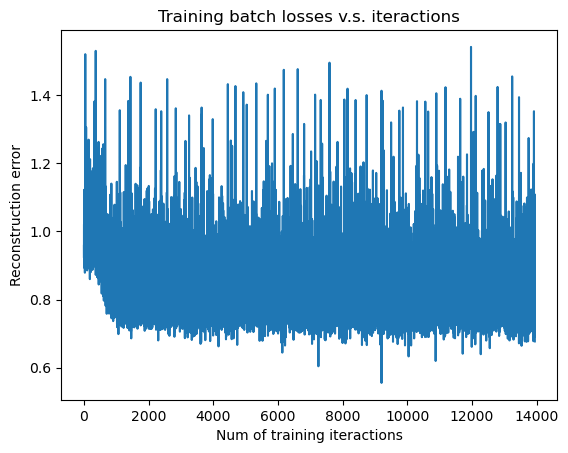

In [41]:
tf.compat.v1.disable_eager_execution()
model.fit(train_x, validation_set=test_x)


## Make predictions on val - Free Energy

In [42]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)


INFO:tensorflow:Restoring parameters from C:\Users\karti\Desktop\CCFD_files\Model\rbm_model.ckpt


## AUC-ROC curve on val

In [43]:
auc(test_y, test_cost)

0.9632772134728917

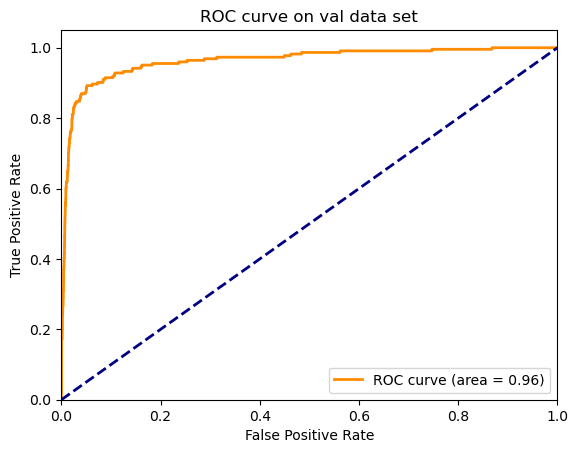

In [51]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

## Distribution for FE on val set - fraud and non-fraud

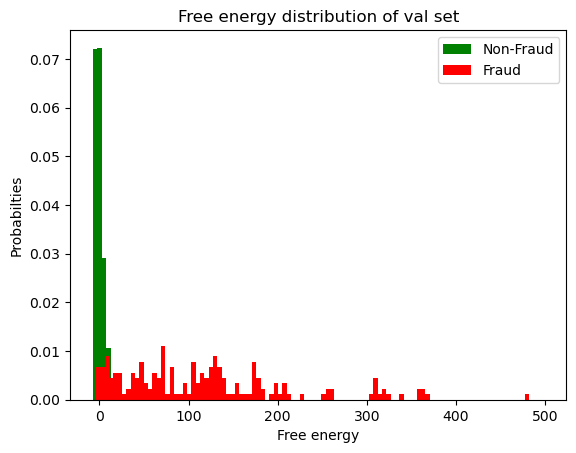

In [44]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=True, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=True, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

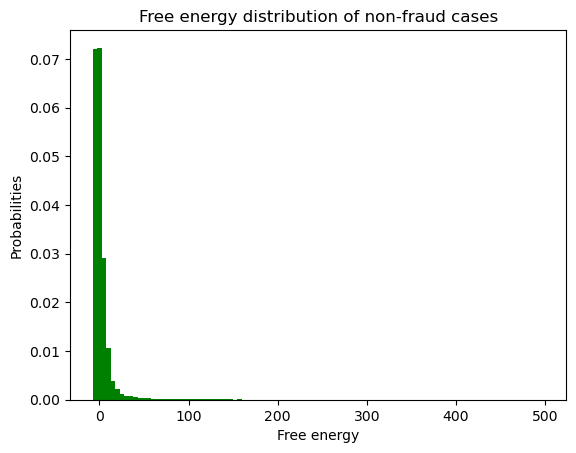

In [45]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=1)
plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

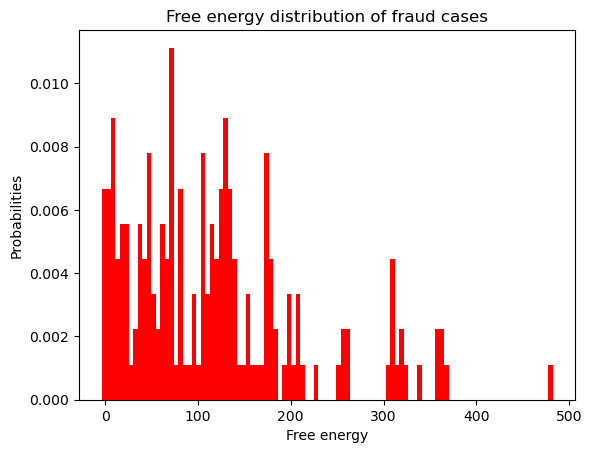

In [46]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=1)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

## Finding a threshold for real time fraud detector

### Precision Recall Curve in general

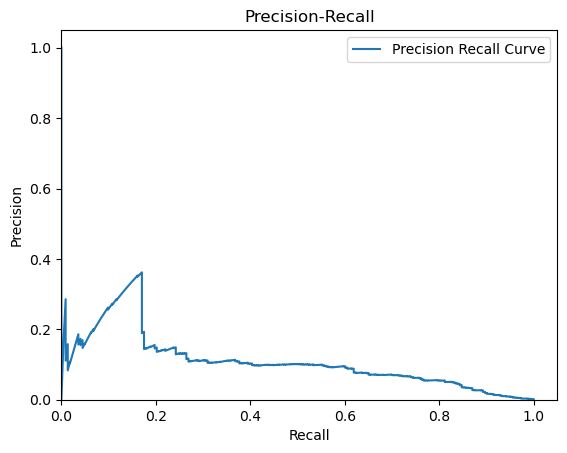

In [47]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(lines):
    for precision, recall, label in lines:
        plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall')
    plt.legend(loc="upper right")
    plt.show()
    
lines = []
precision, recall, threshold = precision_recall_curve(test_y, test_cost)

lines.append( (precision, recall, 'Precision Recall Curve') )
plot_precision_recall(lines)

### Finding a threshold of Free Energy on range(0, 200) that best balances Precision and Recall

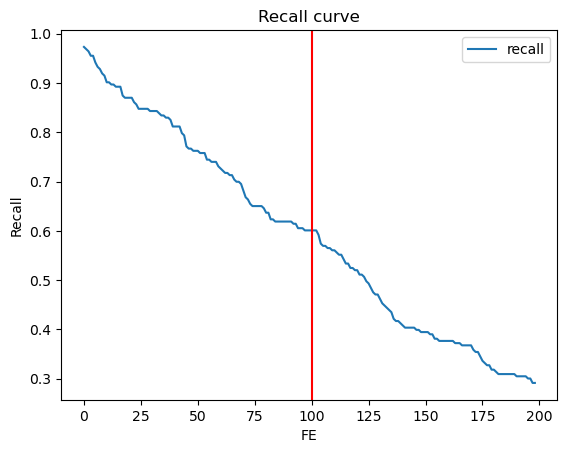

In [48]:
precisions = []
recalls = []
all_pos = sum(test_y)
for threshold in range(1, 200):
    all_predicted = sum(test_cost > threshold)
    TP = sum((test_cost > threshold) & (test_y == 1))
    
    precisions.append(TP  / all_predicted)
    recalls.append(TP / all_pos)

plt.plot( recalls, label = 'recall')
plt.axvline(100, color = 'red')

plt.title("Recall curve")
plt.xlabel("FE")
plt.ylabel("Recall")
plt.legend()
plt.show()

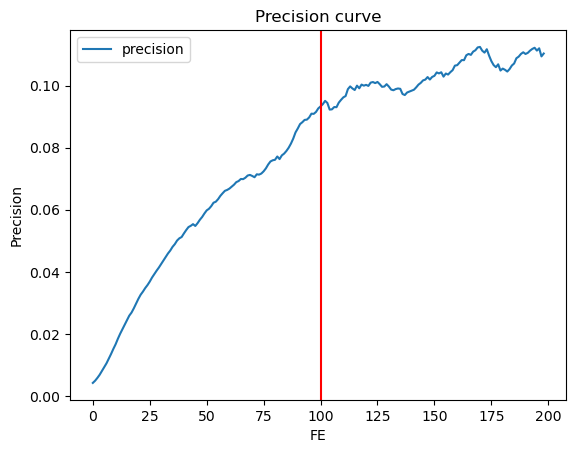

In [49]:
plt.plot( precisions, label = 'precision')
plt.axvline(100, color = 'red')

plt.title("Precision curve")
plt.xlabel("FE")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Take a look at the top 20000 transactions for example ....

In [50]:
value_500 = sorted(test_cost)[-20000]
population_mean = np.mean(test_y)
model_mean_500 = np.mean(test_y[test_cost > value_500])
print("Perc of fraud in val data is: %0.2f%%; perc of fraud in top 20000 by model is: %0.2f%%" % (population_mean*100, model_mean_500*100))

Perc of fraud in val data is: 0.16%; perc of fraud in top 20000 by model is: 1.04%
